# 0 IMPORTAR LIBRERÍAS NECESARIAS

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pandas as pd

# 1. CARGA DE DATOS

In [18]:
# Obtener lista de todas las rutas de las imágenes
image_paths = glob.glob("C:\\Users\\monit\\Desktop\\11-image\\train\\*") 

if image_paths:
    print("Imágenes encontradas:")
    print(f"Total de imágenes encontradas: {len(image_paths)}")


Imágenes encontradas:
Total de imágenes encontradas: 25000


# 2. MOSTRAR 9 IMAGENES DE PERROS Y 9 IMAGENES DE GATOS

In [19]:
# Separar imágenes de perros y gatos
dog_images = [path for path in image_paths if 'dog' in path.lower()]
cat_images = [path for path in image_paths if 'cat' in path.lower()]

print(f"Total de imágenes de perros: {len(dog_images)}")
print(f"Total de imágenes de gatos: {len(cat_images)}")

Total de imágenes de perros: 12500
Total de imágenes de gatos: 12500


In [20]:
# Seleccionar 9 imágenes de cada categoría
dogs_sample = dog_images[:9]
cats_sample = cat_images[:9]

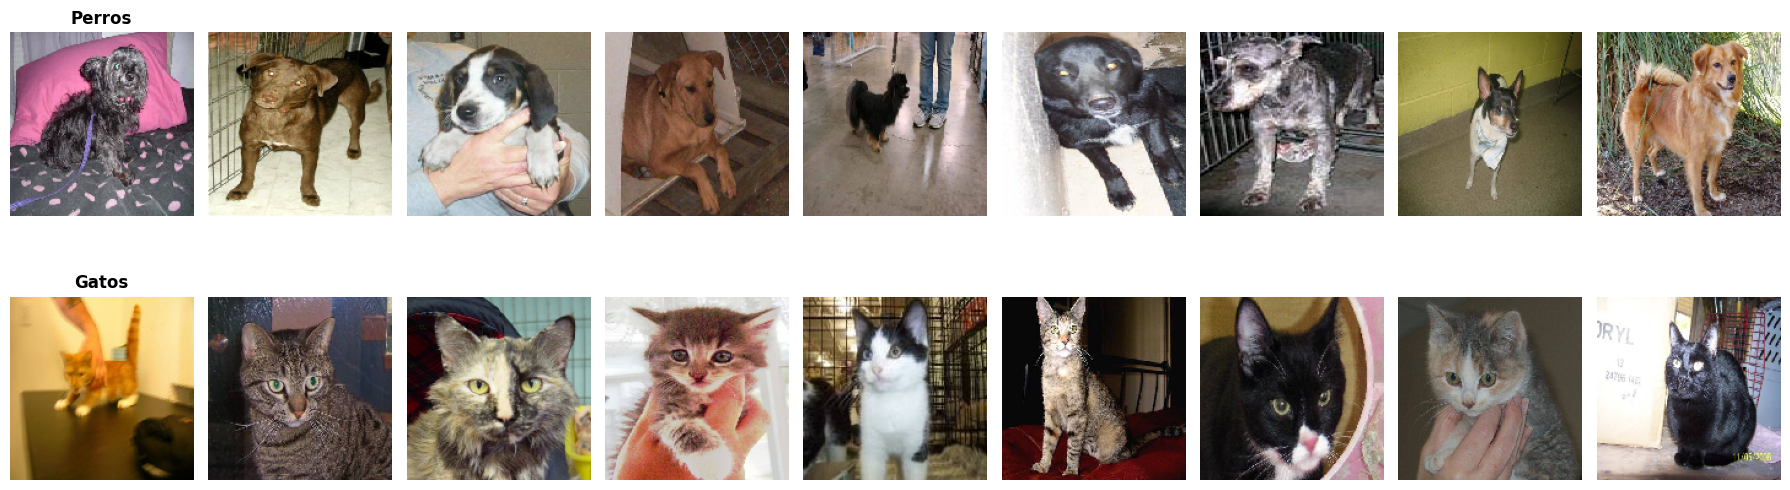

In [21]:
# Crear figura con subcuadrículas: 2 filas x 9 columnas
fig, axes = plt.subplots(2, 9, figsize=(18, 6))

# Fila 1: Perros
for i, img_path in enumerate(dogs_sample):
    img = image.load_img(img_path, target_size=(150, 150))
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Perros', fontsize=12, fontweight='bold')

# Fila 2: Gatos
for i, img_path in enumerate(cats_sample):
    img = image.load_img(img_path, target_size=(150, 150))
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Gatos', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# 3. CONVERTIR UNA IMAGEN A NÚMEROS PARA VER SU FORMA

In [22]:
# Convertir imagen a array (matriz de números)
img_array = image.img_to_array(img)
print(f"Forma del array: {img_array.shape}")  # (alto, ancho, canales de color)
print(f"Rango de valores: {img_array.min()} a {img_array.max()}") # Los colores se forman mezclando 3 colores básicos: Rojo (R), Verde (G), Azul (B). Cada color tiene un valor de 0 a 255

# Ejemplo: ver los primeros valores
print(f"\nPrimeros valores del pixel superior izquierdo:")
print(img_array[0, 0])  # RGB: [Rojo, Verde, Azul]

Forma del array: (150, 150, 3)
Rango de valores: 0.0 a 255.0

Primeros valores del pixel superior izquierdo:
[247. 240. 212.]


# 4. PREPARAR TODAS LAS IMÁGENES

In [23]:
# Definir tamaño estándar para todas las imágenes
IMG_SIZE = (150, 150)  # Todas las imágenes tendrán 150x150 pixels (debe coincidir con el modelo)

# Listas para guardar imágenes y etiquetas
images = []
labels = []

# IMPORTANTE: Usar solo un subconjunto de imágenes para no quedarse sin memoria
MAX_IMAGES = 25000  # Procesar solo 25000 imágenes.

print(f"Cargando máximo {MAX_IMAGES} imágenes...")
for i, img_path in enumerate(image_paths[:MAX_IMAGES]):
    
    # Cargar imagen con el tamaño definido
    img = image.load_img(img_path, target_size=IMG_SIZE)
    
    # Convertir a array
    img_array = image.img_to_array(img)
    
    # Normalizar: convertir valores de 0-255 a 0-1
    img_array = img_array / 255.0
    
    # Guardar
    images.append(img_array)
    
    # Extraer etiqueta del nombre del archivo
    # Ejemplo: si el archivo se llama "gato_001.jpg", la etiqueta sería "gato"
    label = os.path.basename(img_path).split('.')[0]
    labels.append(label)
    
    if (i + 1) % 200 == 0:
        print(f"Procesadas {i + 1} imágenes...")

print(f"\n✓ Total de imágenes procesadas: {len(images)}")
print(f"✓ Total de etiquetas: {len(labels)}")
print(f"✓ Categorías únicas: {set(labels)}")

Cargando máximo 25000 imágenes...
Procesadas 200 imágenes...
Procesadas 400 imágenes...
Procesadas 600 imágenes...
Procesadas 800 imágenes...
Procesadas 1000 imágenes...
Procesadas 1200 imágenes...
Procesadas 1400 imágenes...
Procesadas 1600 imágenes...
Procesadas 1800 imágenes...
Procesadas 2000 imágenes...
Procesadas 2200 imágenes...
Procesadas 2400 imágenes...
Procesadas 2600 imágenes...
Procesadas 2800 imágenes...
Procesadas 3000 imágenes...
Procesadas 3200 imágenes...
Procesadas 3400 imágenes...
Procesadas 3600 imágenes...
Procesadas 3800 imágenes...
Procesadas 4000 imágenes...
Procesadas 4200 imágenes...
Procesadas 4400 imágenes...
Procesadas 4600 imágenes...
Procesadas 4800 imágenes...
Procesadas 5000 imágenes...
Procesadas 5200 imágenes...
Procesadas 5400 imágenes...
Procesadas 5600 imágenes...
Procesadas 5800 imágenes...
Procesadas 6000 imágenes...
Procesadas 6200 imágenes...
Procesadas 6400 imágenes...
Procesadas 6600 imágenes...
Procesadas 6800 imágenes...
Procesadas 7000 im

In [24]:
# Convertir listas a arrays de NumPy
X = np.array(images)  # X = datos (imágenes)
print(f"Forma de X: {X.shape}")  # (num_imágenes, alto, ancho, canales)

# Convertir etiquetas de texto a números
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)  # y = etiquetas (0, 1)
print(f"Forma de y: {y.shape}")
print(f"\nEjemplo de conversión:")
print(f"  {labels[0]} → {y[0]}")
print(f"  {labels[12501]} → {y[12501]}")

Forma de X: (25000, 150, 150, 3)
Forma de y: (25000,)

Ejemplo de conversión:
  cat → 0
  dog → 1


In [25]:
# 1. Ver las primeras 5 y últimas 5 etiquetas
print("Primeras 5 etiquetas:")
for i in range(min(5, len(labels))):
    print(f"  {i}: {labels[i]}")

print("\nÚltimas 5 etiquetas:")
for i in range(max(0, len(labels) - 5), len(labels)):
    print(f"  {i}: {labels[i]}")

# 2. Contar cuántas imágenes hay de cada categoría
conteo = Counter(labels)
print(f"\n📊 Conteo por categoría:")
for categoria, cantidad in conteo.items():
    print(f"  {categoria}: {cantidad} imágenes")

# 3. Ver qué categorías únicas existen
print(f"\n🏷️ Categorías únicas encontradas: {sorted(set(labels))}")

# 4. Verificar algunas rutas y sus etiquetas
print(f"\n🔍 Verificación ruta → etiqueta (primeras 4):")
for i in range(min(4, len(image_paths))):
    filename = os.path.basename(image_paths[i])
    print(f"  {i}: {filename} → '{labels[i]}'")

# Verificar posiciones 12501-12504
print(f"\n🔍 Verificación ruta → etiqueta (desde 12501 hasta 12504):")
for i in range(12501, min(12505, len(image_paths))):
    if i < len(image_paths):
        filename = os.path.basename(image_paths[i])
        print(f"  {i}: {filename} → '{labels[i]}'")

Primeras 5 etiquetas:
  0: cat
  1: cat
  2: cat
  3: cat
  4: cat

Últimas 5 etiquetas:
  24995: dog
  24996: dog
  24997: dog
  24998: dog
  24999: dog

📊 Conteo por categoría:
  cat: 12500 imágenes
  dog: 12500 imágenes

🏷️ Categorías únicas encontradas: ['cat', 'dog']

🔍 Verificación ruta → etiqueta (primeras 4):
  0: cat.0.jpg → 'cat'
  1: cat.1.jpg → 'cat'
  2: cat.10.jpg → 'cat'
  3: cat.100.jpg → 'cat'

🔍 Verificación ruta → etiqueta (desde 12501 hasta 12504):
  12501: dog.1.jpg → 'dog'
  12502: dog.10.jpg → 'dog'
  12503: dog.100.jpg → 'dog'
  12504: dog.1000.jpg → 'dog'


# 6. TRAIN TEST SPLIT

In [26]:
# Dividir datos: 80% entrenamiento, 20% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # 20% para pruebas
    random_state=0  
)

print(f"Datos de entrenamiento: {X_train.shape[0]} imágenes")
print(f"Datos de prueba: {X_test.shape[0]} imágenes")

Datos de entrenamiento: 20000 imágenes
Datos de prueba: 5000 imágenes


# 7. MODELADO (Red Neuronal)

In [ ]:
model = Sequential([
    # Bloque 1
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    # Bloque 2
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    # Bloque 3
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    # Bloque 4
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    # Clasificador
    Flatten(),
    Dropout(0.5),  # Reduce overfitting
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.summary()

c:\Users\monit\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,812,482 (25.99 MB)

 Trainable params: 6,812,482 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

# 8. COMPILADO

In [28]:
# Compilar el modelo
model.compile(
    optimizer='adam',  # Algoritmo para ajustar pesos
    loss='sparse_categorical_crossentropy',  # Función de error
    metrics=['accuracy']  # Métrica para evaluar
)

print("✓ Modelo compilado y listo para entrenar")

✓ Modelo compilado y listo para entrenar


# 9. ENTRENAMOS EL MODELO

In [29]:
X_train_2, X_val, y_train_2, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=0  # 0.20 * 0.8 = 0.2 del total
)
print(f"Datos de entrenamiento finales: {X_train_2.shape[0]} imágenes")
print(f"Datos de validación: {X_val.shape[0]} imágenes")

Datos de entrenamiento finales: 16000 imágenes
Datos de validación: 4000 imágenes


In [30]:
# Entrenar el modelo
history = model.fit(
    X_train_2, y_train_2,  # Datos de entrenamiento
    epochs=6,  # Número de veces que verá todos los datos
    validation_data=(X_val, y_val),  # Datos para  varlidar validation_split = 0.2
    verbose=1  # Mostrar progreso
)

print("\n✓ Entrenamiento completado")

Epoch 1/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 199s 392ms/step - accuracy: 0.6062 - loss: 0.6472 - val_accuracy: 0.6883 - val_loss: 0.5792
Epoch 2/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 189s 377ms/step - accuracy: 0.7235 - loss: 0.5480 - val_accuracy: 0.7610 - val_loss: 0.4848
Epoch 3/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 178s 356ms/step - accuracy: 0.7804 - loss: 0.4671 - val_accuracy: 0.8142 - val_loss: 0.4110
Epoch 4/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 190s 380ms/step - accuracy: 0.8129 - loss: 0.4113 - val_accuracy: 0.8058 - val_loss: 0.4270
Epoch 5/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 149s 297ms/step - accuracy: 0.8370 - loss: 0.3673 - val_accuracy: 0.8385 - val_loss: 0.3675
Epoch 6/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 196s 392ms/step - accuracy: 0.8601 - loss: 0.3268 - val_accuracy: 0.8602 - val_loss: 0.3319

✓ Entrenamiento completado


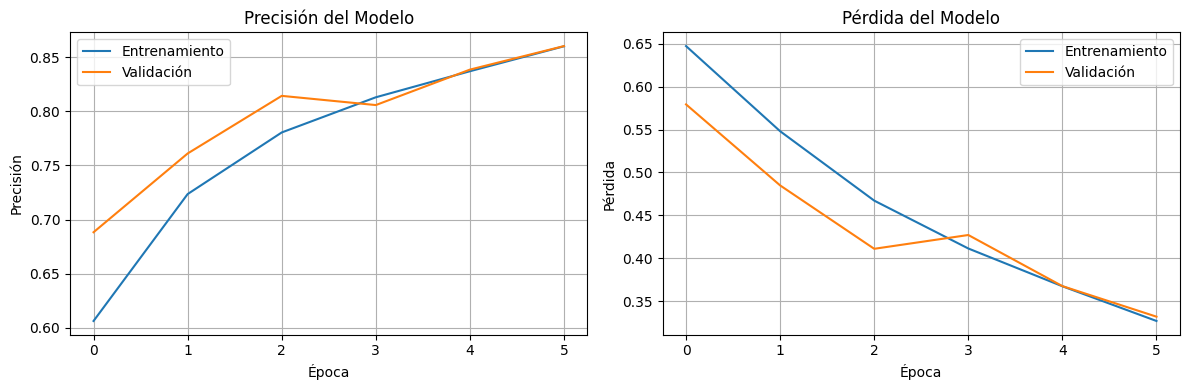

In [31]:
# Graficar la precisión
plt.figure(figsize=(12, 4))

# Gráfica 1: Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del Modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Gráfica 2: Pérdida (error)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [32]:
# Evaluar en datos de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"📊 Resultados en datos de prueba:")
print(f"   Precisión: {test_accuracy * 100:.2f}%")
print(f"   Pérdida: {test_loss:.4f}")

📊 Resultados en datos de prueba:
   Precisión: 86.76%
   Pérdida: 0.3067


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


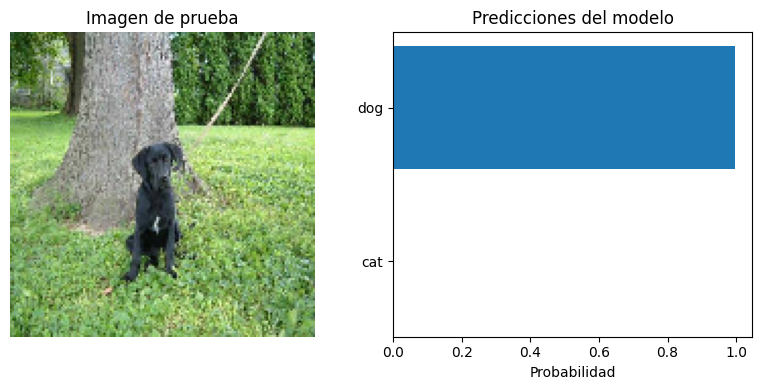


🎯 Predicción:
   Clase real: dog
   Clase predicha: dog
   Confianza: 99.74%


In [33]:
# Seleccionar una imagen de prueba
test_index = 0
test_image = X_test[test_index]
true_label = y_test[test_index]

# Hacer predicción (necesita dimensión extra)
prediction = model.predict(test_image.reshape(1, 150, 150, 3))
predicted_class = np.argmax(prediction)  # Clase con mayor probabilidad

# Visualizar resultado
plt.figure(figsize=(8, 4))

# Imagen
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title(f"Imagen de prueba")
plt.axis('off')

# Probabilidades
plt.subplot(1, 2, 2)
classes = label_encoder.classes_
plt.barh(classes, prediction[0])
plt.xlabel('Probabilidad')
plt.title('Predicciones del modelo')
plt.tight_layout()
plt.show()

# Resultado
print(f"\n🎯 Predicción:")
print(f"   Clase real: {label_encoder.inverse_transform([true_label])[0]}")
print(f"   Clase predicha: {label_encoder.inverse_transform([predicted_class])[0]}")
print(f"   Confianza: {prediction[0][predicted_class] * 100:.2f}%")

# 12. TEST CON UNA IMAGEN DE INTERNET 

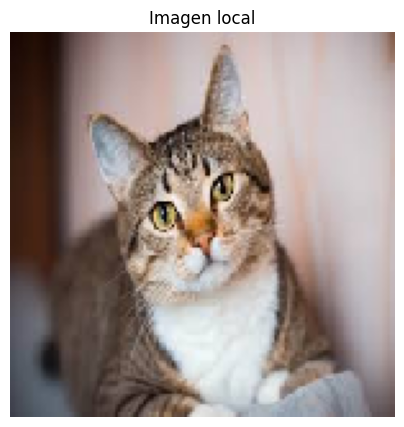

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

🎯 Predicción: cat
   Confianza: 99.07%


In [34]:
# Ruta a la imagen descargada
ruta_imagen = "C:\\Users\\monit\\Desktop\\11-image\\test-gato.jpg"  # Cambia esta ruta

# Cargar y procesar la imagen
img_local = image.load_img(ruta_imagen, target_size=(150, 150))

# Mostrar
plt.figure(figsize=(5, 5))
plt.imshow(img_local)
plt.title("Imagen local")
plt.axis('off')
plt.show()

# Convertir a array, normalizar y predecir
img_array = image.img_to_array(img_local)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predicción
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

print(f"\n🎯 Predicción: {label_encoder.inverse_transform([predicted_class])[0]}")
print(f"   Confianza: {prediction[0][predicted_class] * 100:.2f}%")

# 13 OPTIMIZAR EL MODELO 

In [ ]:
best_model = Sequential ([
    # Bloque 1
    Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(0.001), input_shape=(150,150,3)),
    BatchNormalization(), # Una capa que normaliza los valores dentro de la red para que no se “descontrolen”
    LeakyReLU(), # Una versión mejorada de ReLU que evita que las neuronas “mueran”.
    MaxPooling2D(2,2),

    # Bloque 2
    Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(2,2),

    # Bloque 3
    Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(2,2),

    # Bloque 4
    Conv2D(256, (3,3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(2,2),

    Flatten(),

    # Clasificador
    Dense(256, kernel_regularizer=l2(0.001)),  # Una técnica de regularización que penaliza pesos demasiado grandes.
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.4), # 0.5 es un valor muy alto para una CNN profunda.

    Dense(2, activation='softmax')
])

c:\Users\monit\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
best_model.compile(
    optimizer=Adam(learning_rate=0.0005), # Las CNN profundas aprenden mejor con un paso más pequeño.
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
    )

In [ ]:
callbacks = [ EarlyStopping(patience=5, restore_best_weights=True), #  Detiene el entrenamiento cuando ya no mejora.
             ReduceLROnPlateau(factor=0.2, patience=3), # Baja el learning rate cuando el modelo se estanca. 
             ModelCheckpoint("mejor_modelo.h5", save_best_only=True) ] # Guarda el mejor modelo durante el entrenamiento.

In [38]:
history_2 = best_model.fit(
    X_train_2, y_train_2,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.6723 - loss: 1.5055

500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 618ms/step - accuracy: 0.7128 - loss: 1.2375 - val_accuracy: 0.6812 - val_loss: 1.0212 - learning_rate: 5.0000e-04
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.7737 - loss: 0.8688

500/500 ━━━━━━━━━━━━━━━━━━━━ 337s 673ms/step - accuracy: 0.7876 - loss: 0.8027 - val_accuracy: 0.7880 - val_loss: 0.7432 - learning_rate: 5.0000e-04
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.8086 - loss: 0.6741

500/500 ━━━━━━━━━━━━━━━━━━━━ 323s 645ms/step - accuracy: 0.8113 - loss: 0.6546 - val_accuracy: 0.7655 - val_loss: 0.6892 - learning_rate: 5.0000e-04
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 253s 505ms/step - accuracy: 0.8345 - loss: 0.5697 - val_accuracy: 0.6860 - val_loss: 0.8830 - learning_rate: 5.0000e-04
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.8508 - loss: 0.5209

500/500 ━━━━━━━━━━━━━━━━━━━━ 259s 519ms/step - accuracy: 0.8484 - loss: 0.5253 - val_accuracy: 0.8453 - val_loss: 0.5202 - learning_rate: 5.0000e-04
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 238s 477ms/step - accuracy: 0.8591 - loss: 0.5069 - val_accuracy: 0.8240 - val_loss: 0.5634 - learning_rate: 5.0000e-04
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 236s 472ms/step - accuracy: 0.8674 - loss: 0.4899 - val_accuracy: 0.8342 - val_loss: 0.5654 - learning_rate: 5.0000e-04
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 236s 472ms/step - accuracy: 0.8813 - loss: 0.4775 - val_accuracy: 0.6820 - val_loss: 0.9686 - learning_rate: 5.0000e-04
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9246 - loss: 0.3697

500/500 ━━━━━━━━━━━━━━━━━━━━ 226s 452ms/step - accuracy: 0.9351 - loss: 0.3409 - val_accuracy: 0.8733 - val_loss: 0.4610 - learning_rate: 1.0000e-04
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 230s 460ms/step - accuracy: 0.9513 - loss: 0.2783 - val_accuracy: 0.8205 - val_loss: 0.6116 - learning_rate: 1.0000e-04
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9747 - loss: 0.2255

500/500 ━━━━━━━━━━━━━━━━━━━━ 227s 454ms/step - accuracy: 0.9722 - loss: 0.2287 - val_accuracy: 0.8953 - val_loss: 0.4315 - learning_rate: 1.0000e-04
Epoch 12/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 223s 446ms/step - accuracy: 0.9753 - loss: 0.2074 - val_accuracy: 0.8810 - val_loss: 0.4895 - learning_rate: 1.0000e-04
Epoch 13/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 228s 455ms/step - accuracy: 0.9814 - loss: 0.1872 - val_accuracy: 0.8925 - val_loss: 0.4352 - learning_rate: 1.0000e-04
Epoch 14/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 219s 438ms/step - accuracy: 0.9869 - loss: 0.1708 - val_accuracy: 0.8890 - val_loss: 0.4713 - learning_rate: 1.0000e-04
Epoch 15/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9921 - loss: 0.1550

500/500 ━━━━━━━━━━━━━━━━━━━━ 222s 444ms/step - accuracy: 0.9942 - loss: 0.1494 - val_accuracy: 0.9010 - val_loss: 0.4129 - learning_rate: 2.0000e-05
Epoch 16/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9968 - loss: 0.1396

500/500 ━━━━━━━━━━━━━━━━━━━━ 232s 464ms/step - accuracy: 0.9974 - loss: 0.1359 - val_accuracy: 0.9015 - val_loss: 0.4128 - learning_rate: 2.0000e-05
Epoch 17/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 221s 443ms/step - accuracy: 0.9984 - loss: 0.1285 - val_accuracy: 0.8928 - val_loss: 0.4532 - learning_rate: 2.0000e-05
Epoch 18/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 221s 441ms/step - accuracy: 0.9979 - loss: 0.1234 - val_accuracy: 0.8975 - val_loss: 0.4635 - learning_rate: 2.0000e-05
Epoch 19/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 279s 475ms/step - accuracy: 0.9986 - loss: 0.1174 - val_accuracy: 0.8965 - val_loss: 0.4569 - learning_rate: 2.0000e-05
Epoch 20/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 245s 489ms/step - accuracy: 0.9992 - loss: 0.1135 - val_accuracy: 0.9075 - val_loss: 0.4309 - learning_rate: 4.0000e-06


In [ ]:
df = pd.DataFrame(history_2.history) 
print(df)

    accuracy      loss  val_accuracy  val_loss  learning_rate
0   0.712812  1.237516       0.68125  1.021161       0.000500
1   0.787562  0.802653       0.78800  0.743155       0.000500
2   0.811312  0.654630       0.76550  0.689157       0.000500
3   0.834500  0.569745       0.68600  0.883036       0.000500
4   0.848375  0.525269       0.84525  0.520175       0.000500
5   0.859062  0.506947       0.82400  0.563448       0.000500
6   0.867437  0.489865       0.83425  0.565446       0.000500
7   0.881312  0.477515       0.68200  0.968579       0.000500
8   0.935125  0.340858       0.87325  0.460978       0.000100
9   0.951312  0.278271       0.82050  0.611580       0.000100
10  0.972250  0.228707       0.89525  0.431540       0.000100
11  0.975250  0.207380       0.88100  0.489510       0.000100
12  0.981375  0.187234       0.89250  0.435155       0.000100
13  0.986938  0.170793       0.88900  0.471315       0.000100
14  0.994187  0.149365       0.90100  0.412894       0.000020
15  0.99

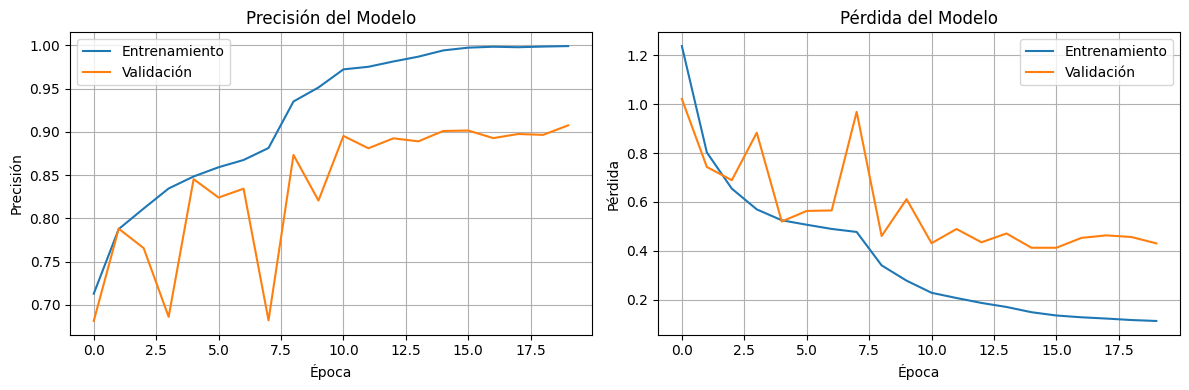

In [40]:
# Graficar la precisión
plt.figure(figsize=(12, 4))

# Gráfica 1: Precisión
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Entrenamiento')
plt.plot(history_2.history['val_accuracy'], label='Validación')
plt.title('Precisión del Modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Gráfica 2: Pérdida (error)
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Entrenamiento')
plt.plot(history_2.history['val_loss'], label='Validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

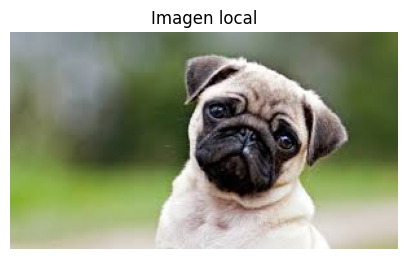

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step

🎯 Predicción: dog
   Confianza: 100.00%


In [ ]:
# 1. Cargar el modelo
modelo = load_model("mejor_modelo.h5")

# 2. Cargar imagen local
img_local_1 = image.load_img(
    r"C:\Users\monit\Desktop\11-image\test-perro.jpg"
)

# 3. Mostrar imagen original
plt.figure(figsize=(5, 5))
plt.imshow(img_local_1)
plt.axis("off")
plt.title("Imagen local")
plt.show()

# 4. REDIMENSIONAR AL TAMAÑO DEL MODELO
img_resized = img_local_1.resize((150, 150))

# 5. Convertir a array y normalizar
img_array = image.img_to_array(img_resized)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# 6. Predicción
prediction = modelo.predict(img_array)
predicted_class = np.argmax(prediction)

print("\n🎯 Predicción:", label_encoder.inverse_transform([predicted_class])[0])
print("   Confianza:", f"{prediction[0][predicted_class] * 100:.2f}%")